# INM701: Neural Networks (Part 2, Oversampled Data)

We look at using TensorFlow/Keras to create a neural network that can accurately predict protein secondary structures.

This notebook is specifically for the oversampled data.

The work presented here is part of the coursework of the INM701 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM701).

### Import Libraries

In [1]:
# Import Relevant Libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import Dataset

Refer to the 'eda-data-processing.ipynb' workbook for more detail on how this dataset was created.

In [2]:
# Create a variable for the path to the directory containing the dataset (and where to work)
path = "/kaggle/input/protein-sequences-16-100"

# Create a variable containing the full path of the dataset
dataset = os.path.join(path, "prot-seq-filtered.csv")

# Create a Pandas DataFrame of the dataset (which is a .csv file)
df = pd.read_csv(dataset, delimiter = ",")

df

,pdb_id,chain_code,seq,sst8,sst3,len
0,1BXL,B,GQVGRQLAIIGDDINR,CCTTHHHHHHHHHTCC,CCCCHHHHHHHHHCCC,16
1,1D9K,P,GNSHRGAIEWEGIESG,CCEECCCCCCCCCCCC,CCEECCCCCCCCCCCC,16
2,1DPU,B,RIQRNKAAALLRLAAR,CCSSHHHHHHHHHHCC,CCCCHHHHHHHHHHCC,16
3,1DXP,C,KGSVVIVGRIILSGRK,CCCBEEEEEEEECCCC,CCCEEEEEEEEECCCC,16
4,1EJH,E,KQYDREFLLDFQFMPA,CCCCHHHHHTTSCCCC,CCCCHHHHHCCCCCCC,16
...,...,...,...,...,...,...
15267,6UUJ,A,GAMVPEGLAAASAAVEALTARLAAAHASAAPVITAVVPPAADPVSL...,CCCCCSTTHHHHHHHHHHHHHHHHHHHHSHHHHHSCCCSSSSHHHH...,CCCCCCCCHHHHHHHHHHHHHHHHHHHHCHHHHHCCCCCCCCHHHH...,100
15268,6V7M,A,MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWEL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHH...,100
15269,6VQX,A,MKVPAFFAANILTIEQIIEAINNDGSAMTSAPEIAGYYAWDAATDA...,CCCCSSTTSSCCCHHHHHHHHHTTSCTTSCHHHHHHHHHHHHHHHS...,CCCCCCCCCCCCCHHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHC...,100
15270,6XVF,F,RWLEGIRKWYYNAAGFNKLGLMRDDTIHENDDVKEAIRRLPENLYN...,CCTHHHHHHHHHHHCGGGGTCCGGGSBCCCHHHHHHHHTSCHHHHH...,CCCHHHHHHHHHHHCHHHHCCCHHHCECCCHHHHHHHHCCCHHHHH...,100


### Set Random Seed and $k$-mer Size

We choose a seed for reproducibility and a sensible $k$-mer size.

In [3]:
# k-mer size and seed choice

kmer_size = 3
randomer = 50

# Random Seed
random.seed(randomer)
np.random.seed(randomer)
tf.random.set_seed(randomer)
tf.config.experimental.enable_op_determinism()

### Generate $k$-mers
We convert our protein sequences in to $k$-mers, making the problem less computationally expensive. The choice of $k$ affects the performance of the model, with higher $k$ likely leading to less accurate models. This accuracy can vary based on much larger datasets, and with longer protein sequences.

For example, the 3-mers for "GQVGRQ" are:

GQV, QVG, VGR, GRQ

In [4]:
# Define k-mer function (n-gram)
def kmers(seq, k = kmer_size):
    return ([seq[i:i + k] for i in range(len(seq) - k + 1)])

# Apply the k-mer function to the amino acid sequences
df["kmers"] = df["seq"].apply(kmers)

# Find the maximum length of the sequences (we know from previously processing our dataset that it is 100)
maxlen = max(df["len"])
print("Maximum Protein Length:", maxlen)

df.head()

Maximum Protein Length: 100


,pdb_id,chain_code,seq,sst8,sst3,len,kmers
0,1BXL,B,GQVGRQLAIIGDDINR,CCTTHHHHHHHHHTCC,CCCCHHHHHHHHHCCC,16,"[GQV, QVG, VGR, GRQ, RQL, QLA, LAI, AII, IIG, ..."
1,1D9K,P,GNSHRGAIEWEGIESG,CCEECCCCCCCCCCCC,CCEECCCCCCCCCCCC,16,"[GNS, NSH, SHR, HRG, RGA, GAI, AIE, IEW, EWE, ..."
2,1DPU,B,RIQRNKAAALLRLAAR,CCSSHHHHHHHHHHCC,CCCCHHHHHHHHHHCC,16,"[RIQ, IQR, QRN, RNK, NKA, KAA, AAA, AAL, ALL, ..."
3,1DXP,C,KGSVVIVGRIILSGRK,CCCBEEEEEEEECCCC,CCCEEEEEEEEECCCC,16,"[KGS, GSV, SVV, VVI, VIV, IVG, VGR, GRI, RII, ..."
4,1EJH,E,KQYDREFLLDFQFMPA,CCCCHHHHHTTSCCCC,CCCCHHHHHCCCCCCC,16,"[KQY, QYD, YDR, DRE, REF, EFL, FLL, LLD, LDF, ..."


### Pre-processing and Padding

We use the Tokenizer class to transform our protein sequences and secondary structures into sequences of integers, where each integer is an index of a token in a dictionary. A dictionary is made for our 3-mers, and another dictionary is made for our secondary structures. Padding is performed to make the length of each sequence equal.

In [5]:
%%time

# We will use functions from Keras to pre-process our data to be used in the model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# Create Tokenizer class for protein sequences, without making them lowercase
tok_x = Tokenizer(lower = False)
# Fit Tokenizer on protein sequences (k-mers)
tok_x.fit_on_texts(df["kmers"].values)
# Convert protein sequences into sequence of integers and pad where necessary
X = tok_x.texts_to_sequences(df["kmers"].values)
X = sequence.pad_sequences(X, maxlen = maxlen, padding = "post")

# Create Tokenizer class for secondary sequences, and treat every character (element) as a token
tok_y = Tokenizer(char_level = True)
# Fit Tokenizer on secondary structures
tok_y.fit_on_texts(df["sst3"].values)
# Convert secondary structures into sequence of integers and pad where necessary
y = tok_y.texts_to_sequences(df["sst3"].values)
y = sequence.pad_sequences(y, maxlen = maxlen, padding = "post")

X.shape, y.shape

CPU times: user 1.92 s, sys: 28.6 ms, total: 1.95 s
Wall time: 1.99 s


((15272, 100), (15272, 100))

### Training, Validation and Test Split

We split our dataset into training, validation and test sets, where the training set is used to train the model. The validation set is used to choose a sensible model after it has been trained. The test set is used to test the performance of our final candidate model.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 3/4, test_size = 1/4, random_state = randomer)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size = 1/3, test_size = 2/3, random_state = randomer)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11454, 100),
 (11454, 100),
 (1272, 100),
 (1272, 100),
 (2546, 100),
 (2546, 100))

In [7]:
X_train[0], y_train[0]

(array([3272, 2093, 4483,  695,  203, 1554, 2110, 1956, 2856, 3513, 2841,
        2369, 1917, 3529, 1159,  110, 1527,  943, 3428, 4868, 4080, 6729,
        6249, 6991, 5684, 3603, 2648, 2493, 1682,  621, 1677, 1171, 2116,
         692, 1320, 3613, 4117, 4087, 1683, 4427, 2159, 2269, 3387, 2341,
        1270,  121,  365,  161, 2364, 2950, 4291, 5756, 4993, 4479, 3168,
        3306, 4084, 5154,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32),
 array([1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3,
        3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

### Oversampling Method

In "Oversampling 1", we extract protein sequences where class 3 (E) is the majority class in the corresponding secondary structure. This way, we aren't increasing class 1 (C) at a faster rate, which is the majority class in the overall dataset (see 'eda-data-processing.ipynb' in the repository). There are 24 of these based on our threshold, and we append these to X_train and y_train (with variables now called nx_ar and ny_ar respectively) 350 times.

In "Oversampling 2", we extract protein sequences where class 2 (H) is the majority class in the corresponding secondary structure. There are 42 of these based on our threshold, and we append these 110 times.

In "Oversampling 3", we extract protein sequences where class 0 (the padding) is sufficiently high. We do this so that class 0 is not heavily less represented in comparison to the other classes. There are 677 of these based on our threshold, and we append these 3 times.

We shuffle the resulting dataset as appropriate.

In [8]:
# Duplicate training set
nx_ar = X_train
ny_ar = y_train

In [9]:
%%time

# Oversampling 1

x_o1 = []
y_o1 = []

for i, y in enumerate(y_train):
    if (np.sum(y == 3) / len(y)) >= 0.6:
        x_o1.append(X_train[i])
        y_o1.append(y)
        
print(len(x_o1))

for i in range(0, 350):
    for i, x in enumerate(x_o1):
        nx_ar = np.vstack((nx_ar, x))
        ny_ar = np.vstack((ny_ar, y_o1[i]))

print(nx_ar.shape, ny_ar.shape)

24
(19854, 100) (19854, 100)
CPU times: user 10.7 s, sys: 7.37 s, total: 18 s
Wall time: 18 s


In [10]:
%%time

# Oversampling 2

x_o2 = []
y_o2 = []

for i, y in enumerate(y_train):
    if (np.sum(y == 2) / len(y)) >= 0.8:
        x_o2.append(X_train[i])
        y_o2.append(y)

print(len(x_o2))

for i in range(0, 110):
    for i, x in enumerate(x_o2):
        nx_ar = np.vstack((nx_ar, x))
        ny_ar = np.vstack((ny_ar, y_o2[i]))

print(nx_ar.shape, ny_ar.shape)

42
(24474, 100) (24474, 100)
CPU times: user 15.7 s, sys: 10.4 s, total: 26.1 s
Wall time: 26.1 s


In [11]:
%%time

# Oversampling 3

x_o3 = []
y_o3 = []

for i, y in enumerate(y_train):
    if (np.sum(y == 0) / len(y)) >= 0.8:
        x_o3.append(X_train[i])
        y_o3.append(y)

print(len(x_o3))

for i in range(0, 3):
    for i, x in enumerate(x_o3):
        nx_ar = np.vstack((nx_ar, x))
        ny_ar = np.vstack((ny_ar, y_o3[i]))

print(nx_ar.shape, ny_ar.shape)

677
(26505, 100) (26505, 100)
CPU times: user 7.84 s, sys: 5.02 s, total: 12.9 s
Wall time: 12.9 s


In [12]:
# Repeat seed (if needed)
np.random.seed(randomer)

# Generate random indices (we want to shuffle our training set)
indices = np.random.permutation(len(nx_ar))

# Shuffle both arrays using the same indices
X_train_new = nx_ar[indices]
y_train_new = ny_ar[indices]

X_train_new, y_train_new

(array([[ 937, 2726, 3010, ...,    0,    0,    0],
        [5611, 1463,  625, ...,    0,    0,    0],
        [3720, 2259, 1591, ...,    0,    0,    0],
        ...,
        [ 731,    3, 1281, ...,    0,    0,    0],
        [1021, 2009, 4556, ...,    0,    0,    0],
        [ 817, 1738, 1553, ...,    0,    0,    0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 3, 3, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32))

In [13]:
from sklearn.metrics import classification_report

# Simple way to find out how many instances there are of each class
report1 = classification_report(y_train.flatten(), y_train.flatten(), output_dict = True)
report2 = classification_report(y_train_new.flatten(), y_train_new.flatten(), output_dict = True)

print("Without Oversampling:")
for i in ["0","1","2","3"]:
    print("Number in Class", i, ":", report1[i]["support"], ",", report1[i]["support"] * 100 / report1["weighted avg"]["support"], "%")
    
print("\nWith Oversampling:")
for i in ["0","1","2","3"]:
    print("Number in Class", i, ":", report2[i]["support"], ",", report2[i]["support"] * 100 / report2["weighted avg"]["support"], "%")

Without Oversampling:
Number in Class 0 : 408388 , 35.65461847389558 %
Number in Class 1 : 366060 , 31.959140911471973 %
Number in Class 2 : 239124 , 20.876898899947616 %
Number in Class 3 : 131828 , 11.509341714684826 %

With Oversampling:
Number in Class 0 : 649924 , 24.520807394831163 %
Number in Class 1 : 705695 , 26.624976419543483 %
Number in Class 2 : 645468 , 24.35268817204301 %
Number in Class 3 : 649413 , 24.501528013582345 %


In [14]:
from collections import defaultdict

# Function to visualise distribution of SST-3/SST-8 (taken from EDA workbook, adapted to arrays)
def sst_visualise(array, ss_types, labels, ss_colours, title):
    ss_counts = defaultdict(lambda: 0)

    for row in array:
        for element in row:
            ss_counts[element] += 1

    plt.bar(range(len(ss_types)), height = [ss_counts[ss] for ss in ss_types], tick_label = labels, edgecolor = "black", width = 0.75, zorder = 3, color = ss_colours)
    plt.title(title)
    plt.xlabel("Element")
    plt.ylabel("Frequency")
    plt.show()

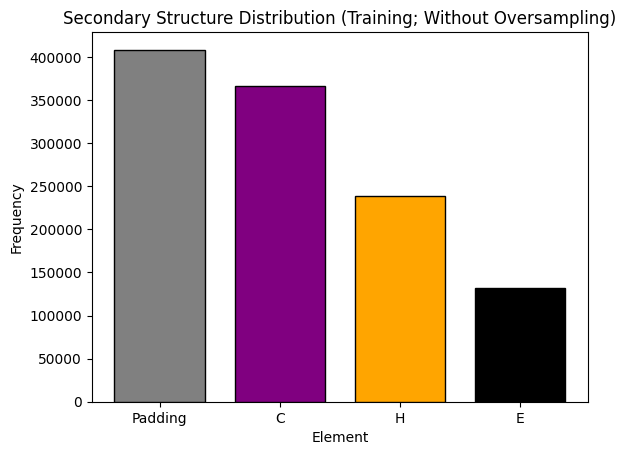

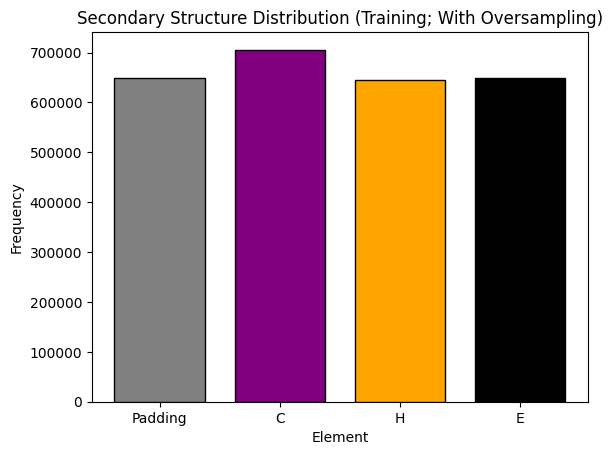

In [15]:
# Define elements for SST-3 and SST-8, and custom colours
ss_types = list(set(np.ravel(y_train)))
labels = ["Padding", "C", "H", "E"]
ss_colours = ["grey", "purple", "orange", "black"]

# Plot for training set distribution before oversampling
sst_visualise(y_train, ss_types, labels, ss_colours, "Secondary Structure Distribution (Training; Without Oversampling)")

# Plot for training set distribution after oversampling
sst_visualise(y_train_new, ss_types, labels, ss_colours, "Secondary Structure Distribution (Training; With Oversampling)")

In [16]:
# Perform One-hot Encoding (important for neural networks)

from tensorflow.keras.utils import to_categorical

y_train_new_hot = to_categorical(y_train_new)
y_val_hot = to_categorical(y_val)
y_test_hot = to_categorical(y_test)

### Import Neural Network Functions and Define Q3 Accuracy Metric

We are interested in using neural networks for multi-output classification, so we import the relevant functions from TensorFlow. Q3 accuracy is an important metric for assessing the accuracy of our models, as it excludes the padding class in its calculations (it is otherwise equivalent to 'accuracy_score' from scikit-learn).

In [17]:
# Import relevant functions for Neural Networks

from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
# Function from KirkDCO on Kaggle (which was made by helme)

from keras import backend as K

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

### Neural Network Model (Model 1, Adam)

We describe a neural network model without any regularisation, one hidden layer with the ReLU activation function, and the output layer with the Softmax activation function. The number of epochs is 150, with the batch size and learning rate as 128 and 0.001 respectively. The optimiser used is Adaptive Moment Estimation (Adam).

#### With Oversampling

### Set Hyperparameters

In [19]:
# Select input and output dimensions (number of 3-mers and number of possible secondary structure elements (3 + padding = 4))

n_kmers = len(tok_x.word_index) + 1
n_elems = len(tok_y.word_index) + 1

# Select number of epochs, batch size, and learning rate
n_epochs = 150
batch_size = 128
learning_rate = 0.001

### Define Model 1

In [20]:
# Define a Neural Network model (Model 1)
model_1 = Sequential()
# Create Embedding layer, which turns our indexes (3-mers) into dense vectors of fixed size - 'output_dim' can be adjusted
model_1.add(Embedding(input_dim = n_kmers, output_dim = X_train.shape[0], input_length = maxlen))
# Create Dense layer of 1000 nodes (hidden layer), using the ReLU activation function
model_1.add(Dense(1000, activation = "relu"))
# Create Dense layer of 4 nodes, using the Softmax activation function
model_1.add((Dense(n_elems, input_dim = y_train_new_hot.shape[2], activation = "softmax")))
# Display summary of model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 11454)        91632000  
                                                                 
 dense (Dense)               (None, 100, 1000)         11455000  
                                                                 
 dense_1 (Dense)             (None, 100, 4)            4004      
                                                                 
Total params: 103091004 (393.26 MB)
Trainable params: 103091004 (393.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train Model 1

We train the neural network on the training data, using the one-hot encoded variable 'y_train_new_hot'. The hyperparameters and model are defined as above. We use EarlyStopping to stop the training if the loss does not improve after 5 epochs.

In [21]:
%%time

from tensorflow.keras.optimizers import Adam

# Repeat seed (if needed)
np.random.seed(randomer)
tf.random.set_seed(randomer)
tf.config.experimental.enable_op_determinism()

# Use 'categorical cross-entropy' loss and the Adam optimiser with set learning rate
model_1.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy", q3_acc])
# Stop training when loss has stopped improving, using EarlyStopping
monitor = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 5, verbose = 1, mode = "auto")
# Create variable to store loss and accuracy history, and fit the neural network to the training data
history_1 = model_1.fit(X_train_new, y_train_new_hot, callbacks = [monitor], batch_size = batch_size, epochs = n_epochs, verbose = 1)

Epoch 1/150
208/208 [==============================] - 82s 384ms/step - loss: 0.5298 - accuracy: 0.8034 - q3_acc: 0.7395
Epoch 2/150
208/208 [==============================] - 67s 321ms/step - loss: 0.4994 - accuracy: 0.8106 - q3_acc: 0.7490
Epoch 3/150
208/208 [==============================] - 62s 300ms/step - loss: 0.4967 - accuracy: 0.8118 - q3_acc: 0.7506
Epoch 4/150
208/208 [==============================] - 58s 281ms/step - loss: 0.4953 - accuracy: 0.8122 - q3_acc: 0.7512
Epoch 5/150
208/208 [==============================] - 53s 255ms/step - loss: 0.4951 - accuracy: 0.8125 - q3_acc: 0.7515
Epoch 6/150
208/208 [==============================] - 50s 241ms/step - loss: 0.4943 - accuracy: 0.8127 - q3_acc: 0.7519
Epoch 7/150
208/208 [==============================] - 50s 240ms/step - loss: 0.4937 - accuracy: 0.8127 - q3_acc: 0.7518
Epoch 8/150
208/208 [==============================] - 49s 234ms/step - loss: 0.4936 - accuracy: 0.8129 - q3_acc: 0.7521
Epoch 9/150
208/208 [===========

In [22]:
model_1.save("model_1_os.keras")

829/829 [==============================] - 12s 14ms/step - loss: 0.4892 - accuracy: 0.8137 - q3_acc: 0.7532
Accuracy: 0.813688337802887
Q3 Accuracy: 0.753161609172821


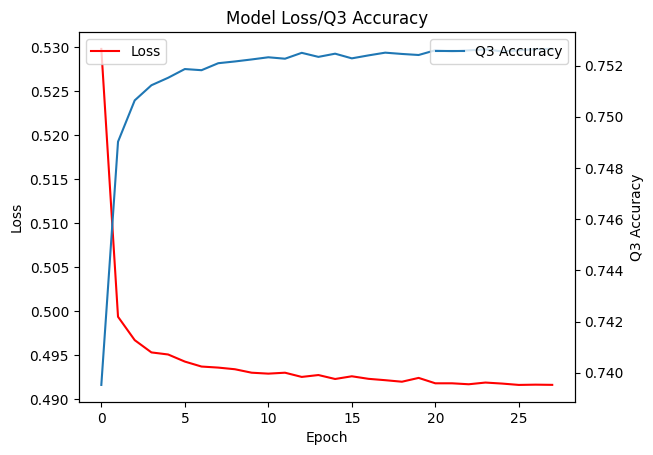

In [23]:
# Default and Q3 Accuracy for Model
evals = model_1.evaluate(X_train_new, y_train_new_hot)
print("Accuracy:", evals[1])
print("Q3 Accuracy:", evals[2])

# Plot model loss
plt.plot(history_1.history["loss"], color = "red")
plt.title("Model Loss/Q3 Accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Plot model Q3 accuracy
plt2 = plt.twinx()
plt2.plot(history_1.history["q3_acc"])
plt.ylabel("Q3 Accuracy")
plt2.legend(["Q3 Accuracy"], loc = "upper right")
plt.savefig("base_model_over.pdf")
plt.show()

### Test Model 1 on Validation Set

We use our trained model to predict the data in the validation set.

In [24]:
%%time

# Convert Q3 accuracy to NumPy object
def q3_num(q3_acc):
    return (sum(q3_acc) / q3_acc.shape[0]).numpy()

# Predict validation set
preds = model_1.predict(X_val)
print(f"Q3 Accuracy: {q3_num(q3_acc(y_val_hot, preds))}")

40/40 [==============================] - 1s 13ms/step
Q3 Accuracy: 0.5343899130821228
CPU times: user 31.6 s, sys: 22.7 ms, total: 31.6 s
Wall time: 32 s


### Neural Network Model (Model 2, RMSprop)

We use the same model and hyperparameters seen in Model 1, but here we use the Root Mean Squared Propagation (RMSprop) optimiser.

### Define Model 2

In [25]:
model_2 = model_1

### Train Model 2

We train the neural network on the training data, using the one-hot encoded variable 'y_train_new_hot'. The hyperparameters and model are defined as above. We use EarlyStopping to stop the training if the loss does not improve after 5 epochs.

In [26]:
%%time

from tensorflow.keras.optimizers import RMSprop

# Repeat seed (if needed)
np.random.seed(randomer)
tf.random.set_seed(randomer)
tf.config.experimental.enable_op_determinism()

# Use 'categorical cross-entropy' loss and the RMSprop optimiser with set learning rate
model_2.compile(loss = "categorical_crossentropy", optimizer = RMSprop(learning_rate = learning_rate), metrics = ["accuracy", q3_acc])
# Stop training when loss has stopped improving, using EarlyStopping
monitor = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 5, verbose = 1, mode = "auto")
# Create variable to store loss and accuracy history, and fit the neural network to the training data
history_2 = model_2.fit(X_train_new, y_train_new_hot, callbacks = [monitor], batch_size = batch_size, epochs = n_epochs, verbose = 1)

Epoch 1/150
208/208 [==============================] - 74s 349ms/step - loss: 0.4892 - accuracy: 0.8136 - q3_acc: 0.7531
Epoch 2/150
208/208 [==============================] - 63s 301ms/step - loss: 0.4891 - accuracy: 0.8138 - q3_acc: 0.7533
Epoch 3/150
208/208 [==============================] - 59s 282ms/step - loss: 0.4890 - accuracy: 0.8137 - q3_acc: 0.7532
Epoch 4/150
208/208 [==============================] - 56s 268ms/step - loss: 0.4890 - accuracy: 0.8137 - q3_acc: 0.7531
Epoch 5/150
208/208 [==============================] - 51s 247ms/step - loss: 0.4889 - accuracy: 0.8137 - q3_acc: 0.7532
Epoch 6/150
208/208 [==============================] - 49s 234ms/step - loss: 0.4889 - accuracy: 0.8137 - q3_acc: 0.7532
Epoch 7/150
208/208 [==============================] - 49s 234ms/step - loss: 0.4889 - accuracy: 0.8136 - q3_acc: 0.7531
Epoch 8/150
208/208 [==============================] - 48s 229ms/step - loss: 0.4889 - accuracy: 0.8137 - q3_acc: 0.7532
Epoch 9/150
208/208 [===========

In [27]:
model_2.save("model_2_os.keras")

829/829 [==============================] - 12s 14ms/step - loss: 0.4918 - accuracy: 0.8136 - q3_acc: 0.7530
Accuracy: 0.8135974407196045
Q3 Accuracy: 0.75304114818573


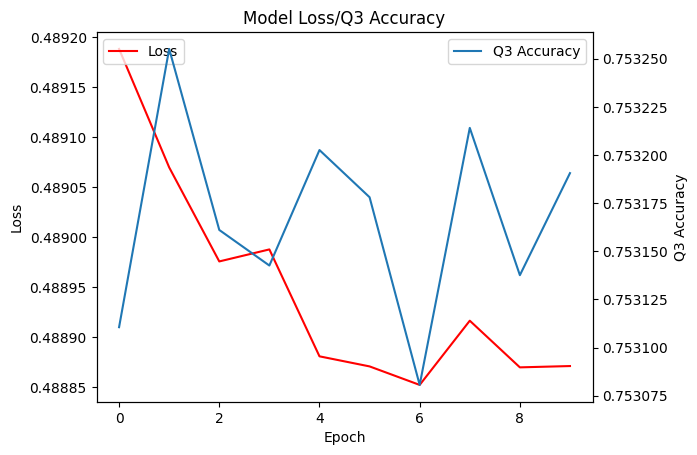

In [28]:
# Default and Q3 Accuracy for Model
evals = model_2.evaluate(X_train_new, y_train_new_hot)
print("Accuracy:", evals[1])
print("Q3 Accuracy:", evals[2])

# Plot model loss
plt.plot(history_2.history["loss"], color = "red")
plt.title("Model Loss/Q3 Accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Plot model Q3 accuracy
plt2 = plt.twinx()
plt2.plot(history_2.history["q3_acc"])
plt.ylabel("Q3 Accuracy")
plt2.legend(["Q3 Accuracy"], loc = "upper right")
plt.savefig("model_2_over.pdf")
plt.show()

### Test Model 2 on Validation Set

We use our trained model to predict the data in the validation set.

In [29]:
# Predict validation set
preds = model_2.predict(X_val)
print(f"Q3 Accuracy: {q3_num(q3_acc(y_val_hot, preds))}")

40/40 [==============================] - 1s 13ms/step
Q3 Accuracy: 0.5341439843177795


### Neural Network Model (Model 3, Adam)

We describe a neural network model without any regularisation, two hidden layers with the ReLU activation function, and the output layer with the Softmax activation function. The other hyperparameters remain the same. The optimiser used is Adam, which provided better results in the comparison of the two models above (Model 1 and Model 2). Notice that the difference in performance of the two optimisers is quite small.

### Define Model 3

In [30]:
# Define a Neural Network model (Model 3)
model_3 = Sequential()
# Create Embedding layer, which turns our indexes (3-mers) into dense vectors of fixed size - 'output_dim' can be adjusted
model_3.add(Embedding(input_dim = n_kmers, output_dim = X_train.shape[0], input_length = maxlen))
# Create Dense layer of 1000 nodes (hidden layer), using the ReLU activation function
model_3.add(Dense(1000, activation = "relu"))
# Create Dense layer of 1000 nodes (hidden layer), using the ReLU activation function
model_3.add(Dense(1000, activation = "relu"))
# Create Dense layer of 4 nodes, using the Softmax activation function
model_3.add((Dense(n_elems, input_dim = y_train_new_hot.shape[2], activation = "softmax")))
# Display summary of model
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 11454)        91632000  
                                                                 
 dense_2 (Dense)             (None, 100, 1000)         11455000  
                                                                 
 dense_3 (Dense)             (None, 100, 1000)         1001000   
                                                                 
 dense_4 (Dense)             (None, 100, 4)            4004      
                                                                 
Total params: 104092004 (397.08 MB)
Trainable params: 104092004 (397.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train Model 3

We train the neural network on the training data, using the one-hot encoded variable 'y_train_new_hot'. The hyperparameters and model are defined as above. We use EarlyStopping to stop the training if the loss does not improve after 5 epochs.

In [31]:
%%time

# Repeat seed (if needed)
np.random.seed(randomer)
tf.random.set_seed(randomer)
tf.config.experimental.enable_op_determinism()

# Use 'categorical cross-entropy' loss and the Adam optimiser with set learning rate
model_3.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy", q3_acc])
# Stop training when loss has stopped improving, using EarlyStopping
monitor = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 5, verbose = 1, mode = "auto")
# Create variable to store loss and accuracy history, and fit the neural network to the training data
history_3 = model_3.fit(X_train_new, y_train_new_hot, callbacks = [monitor], batch_size = batch_size, epochs = n_epochs, verbose = 1)

Epoch 1/150
208/208 [==============================] - 71s 333ms/step - loss: 0.5376 - accuracy: 0.7990 - q3_acc: 0.7402
Epoch 2/150
208/208 [==============================] - 61s 292ms/step - loss: 0.4996 - accuracy: 0.8107 - q3_acc: 0.7492
Epoch 3/150
208/208 [==============================] - 58s 279ms/step - loss: 0.4967 - accuracy: 0.8118 - q3_acc: 0.7507
Epoch 4/150
208/208 [==============================] - 56s 268ms/step - loss: 0.4960 - accuracy: 0.8121 - q3_acc: 0.7510
Epoch 5/150
208/208 [==============================] - 52s 252ms/step - loss: 0.4954 - accuracy: 0.8123 - q3_acc: 0.7513
Epoch 6/150
208/208 [==============================] - 50s 242ms/step - loss: 0.4944 - accuracy: 0.8126 - q3_acc: 0.7517
Epoch 7/150
208/208 [==============================] - 50s 242ms/step - loss: 0.4938 - accuracy: 0.8127 - q3_acc: 0.7518
Epoch 8/150
208/208 [==============================] - 50s 238ms/step - loss: 0.4937 - accuracy: 0.8128 - q3_acc: 0.7519
Epoch 9/150
208/208 [===========

In [32]:
model_3.save("model_3_os.keras")

829/829 [==============================] - 14s 16ms/step - loss: 0.4882 - accuracy: 0.8139 - q3_acc: 0.7534
Accuracy: 0.8138615489006042
Q3 Accuracy: 0.7533910274505615


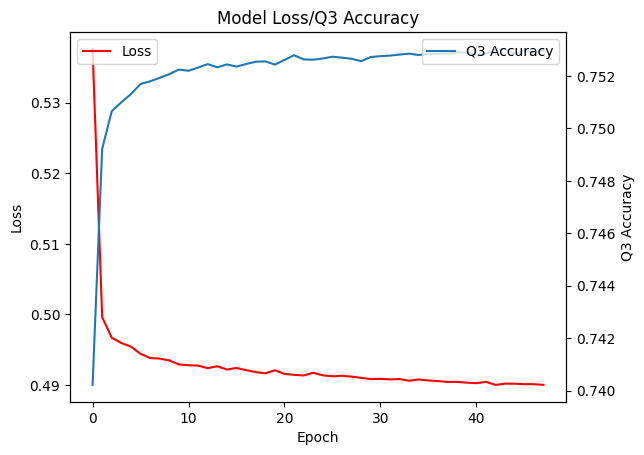

In [33]:
# Default and Q3 Accuracy for Model
evals = model_3.evaluate(X_train_new, y_train_new_hot)
print("Accuracy:", evals[1])
print("Q3 Accuracy:", evals[2])

# Plot model loss
plt.plot(history_3.history["loss"], color = "red")
plt.title("Model Loss/Q3 Accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Plot model Q3 accuracy
plt2 = plt.twinx()
plt2.plot(history_3.history["q3_acc"])
plt.ylabel("Q3 Accuracy")
plt2.legend(["Q3 Accuracy"], loc = "upper right")
plt.savefig("model_3_over.pdf")
plt.show()

### Test Model 3 on Validation Set

We use our trained model to predict the data in the validation set.

In [34]:
# Predict validation set
preds = model_3.predict(X_val)
print(f"Q3 Accuracy: {q3_num(q3_acc(y_val_hot, preds))}")

40/40 [==============================] - 1s 15ms/step
Q3 Accuracy: 0.5336276292800903


### Neural Network Model (Model 4, Adam, Regularised)

We describe a neural network model with dropout regularisation, two hidden layers with the ReLU activation function, and the output layer with the Softmax activation function. The other hyperparameters remain the same. The optimiser used is Adam for the same reason seen previously.

### Define Model 4

In [35]:
# Define a Neural Network model (Model 4)
model_4 = Sequential()
# Create Embedding layer, which turns our indexes (3-mers) into dense vectors of fixed size - 'output_dim' can be adjusted
model_4.add(Embedding(input_dim = n_kmers, output_dim = X_train.shape[0], input_length = maxlen))
# Dropout with rate 0.1
model_4.add(Dropout(0.1))
# Create Dense layer of 1000 nodes (hidden layer), using the ReLU activation function
model_4.add(Dense(1000, activation = "relu"))
# Dropout with rate 0.1
model_4.add(Dropout(0.1))
# Create Dense layer of 1000 nodes (hidden layer), using the ReLU activation function
model_4.add(Dense(1000, activation = "relu"))
# Dropout with rate 0.1
model_4.add(Dropout(0.1))
# Create Dense layer of 4 nodes, using the Softmax activation function
model_4.add((Dense(n_elems, input_dim = y_train_new_hot.shape[2], activation = "softmax")))
# Display summary of model
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 11454)        91632000  
                                                                 
 dropout (Dropout)           (None, 100, 11454)        0         
                                                                 
 dense_5 (Dense)             (None, 100, 1000)         11455000  
                                                                 
 dropout_1 (Dropout)         (None, 100, 1000)         0         
                                                                 
 dense_6 (Dense)             (None, 100, 1000)         1001000   
                                                                 
 dropout_2 (Dropout)         (None, 100, 1000)         0         
                                                                 
 dense_7 (Dense)             (None, 100, 4)           

### Train Model 4

We train the neural network on the training data, using the one-hot encoded variable 'y_train_new_hot'. The hyperparameters and model are defined as above. We use EarlyStopping to stop the training if the loss does not improve after 5 epochs.

In [36]:
%%time

# Repeat seed (if needed)
np.random.seed(randomer)
tf.random.set_seed(randomer)
tf.config.experimental.enable_op_determinism()

# Use 'categorical cross-entropy' loss and the Adam optimiser with set learning rate
model_4.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy", q3_acc])
# Stop training when loss has stopped improving, using EarlyStopping
monitor = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 5, verbose = 1, mode = "auto")
# Create variable to store loss and accuracy history, and fit the neural network to the training data
history_4 = model_4.fit(X_train_new, y_train_new_hot, callbacks = [monitor], batch_size = batch_size, epochs = n_epochs, verbose = 1)

Epoch 1/150
208/208 [==============================] - 74s 349ms/step - loss: 0.5320 - accuracy: 0.8014 - q3_acc: 0.7383
Epoch 2/150
208/208 [==============================] - 65s 310ms/step - loss: 0.5003 - accuracy: 0.8107 - q3_acc: 0.7493
Epoch 3/150
208/208 [==============================] - 61s 295ms/step - loss: 0.4974 - accuracy: 0.8118 - q3_acc: 0.7507
Epoch 4/150
208/208 [==============================] - 59s 284ms/step - loss: 0.4965 - accuracy: 0.8122 - q3_acc: 0.7512
Epoch 5/150
208/208 [==============================] - 55s 267ms/step - loss: 0.4960 - accuracy: 0.8124 - q3_acc: 0.7515
Epoch 6/150
208/208 [==============================] - 53s 257ms/step - loss: 0.4953 - accuracy: 0.8128 - q3_acc: 0.7520
Epoch 7/150
208/208 [==============================] - 54s 257ms/step - loss: 0.4946 - accuracy: 0.8127 - q3_acc: 0.7518
Epoch 8/150
208/208 [==============================] - 53s 254ms/step - loss: 0.4947 - accuracy: 0.8129 - q3_acc: 0.7521
Epoch 9/150
208/208 [===========

In [37]:
model_4.save("model_4_os.keras")

829/829 [==============================] - 13s 15ms/step - loss: 0.4909 - accuracy: 0.8137 - q3_acc: 0.7532
Accuracy: 0.813694417476654
Q3 Accuracy: 0.753169596195221


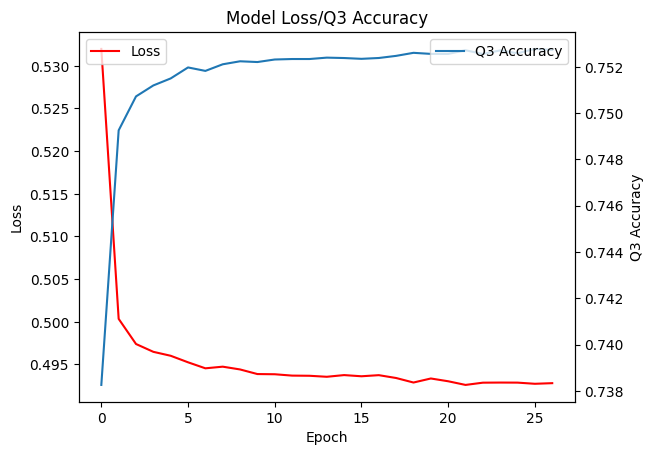

In [38]:
# Default and Q3 Accuracy for Model
evals = model_4.evaluate(X_train_new, y_train_new_hot)
print("Accuracy:", evals[1])
print("Q3 Accuracy:", evals[2])

# Plot model loss
plt.plot(history_4.history["loss"], color = "red")
plt.title("Model Loss/Q3 Accuracy")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss"], loc = "upper left")

# Plot model Q3 accuracy
plt2 = plt.twinx()
plt2.plot(history_4.history["q3_acc"])
plt.ylabel("Q3 Accuracy")
plt2.legend(["Q3 Accuracy"], loc = "upper right")
plt.savefig("model_4_over.pdf")
plt.show()

### Test Model 4 on Validation Set

We use our trained model to predict the data in the validation set.

In [39]:
# Predict validation set
preds = model_4.predict(X_val)
print(f"Q3 Accuracy: {q3_num(q3_acc(y_val_hot, preds))}")

40/40 [==============================] - 1s 15ms/step
Q3 Accuracy: 0.532939076423645


### $k$-Fold Cross-Validation (Oversampled Data)

We perform $k$-fold cross-validation on our oversampled data to determine if the accuracy is approximately equal for different subsets of the data. We use the architecture and hyperparameters from Model 1, which provides the best validation set performance out of the described models.

In [40]:
%%time

from sklearn.model_selection import KFold

# Repeat seed (if needed)
np.random.seed(randomer)
tf.random.set_seed(randomer)
tf.config.experimental.enable_op_determinism()

# K-Fold Cross-Validation

kf = KFold(5, shuffle = True, random_state = randomer)
fold = 1

for train_i, validate_i in kf.split(X_train_new, y_train_new_hot):
    # Define a Neural Network model
    model = Sequential()
    # Create Embedding layer, which turns our indexes (3-mers) into dense vectors of fixed size - 'output_dim' can be adjusted
    model.add(Embedding(input_dim = n_kmers, output_dim = X_train.shape[0], input_length = maxlen))
    # Create Dense layer of 1000 nodes (hidden layer), using the ReLU activation function
    model.add(Dense(1000, activation = "relu"))
    # Create Dense layer of 4 nodes, using the Softmax activation function
    model.add((Dense(n_elems, input_dim = y_train_new_hot.shape[2], activation = "softmax")))
    
    # Use 'categorical cross-entropy' loss and the Adam optimiser with set learning rate
    model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = learning_rate), metrics = ["accuracy", q3_acc])
    # Stop training when loss has stopped improving, using EarlyStopping
    monitor = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 5, verbose = 1, mode = "auto")
    
    print(f"Fold #{fold}, Training Size: {len(X_train_new[train_i])}, Validation Size: {len(X_train_new[validate_i])}")
    print("====================")
    # Fit data to model
    model.fit(X_train_new[train_i], y_train_new_hot[train_i], callbacks = [monitor], batch_size = batch_size, epochs = n_epochs, verbose = 1)
    print("====================")
    # Define validation subset
    y_tester = y_train_new_hot[validate_i]
    # Use model to predict validation subset
    y_preder = model.predict(X_train_new[validate_i])
    print(f"Q3 Accuracy of Fold #{fold}: {round(q3_num(q3_acc(y_tester, y_preder)), 4)}")
    print("====================")
    fold += 1

Fold #1, Training Size: 21204, Validation Size: 5301
Epoch 1/150
166/166 [==============================] - 58s 342ms/step - loss: 0.5376 - accuracy: 0.8000 - q3_acc: 0.7371
Epoch 2/150
166/166 [==============================] - 49s 296ms/step - loss: 0.5004 - accuracy: 0.8101 - q3_acc: 0.7482
Epoch 3/150
166/166 [==============================] - 47s 281ms/step - loss: 0.4974 - accuracy: 0.8114 - q3_acc: 0.7500
Epoch 4/150
166/166 [==============================] - 45s 270ms/step - loss: 0.4958 - accuracy: 0.8118 - q3_acc: 0.7505
Epoch 5/150
166/166 [==============================] - 44s 262ms/step - loss: 0.4955 - accuracy: 0.8121 - q3_acc: 0.7509
Epoch 6/150
166/166 [==============================] - 41s 245ms/step - loss: 0.4952 - accuracy: 0.8123 - q3_acc: 0.7512
Epoch 7/150
166/166 [==============================] - 39s 235ms/step - loss: 0.4942 - accuracy: 0.8125 - q3_acc: 0.7515
Epoch 8/150
166/166 [==============================] - 40s 239ms/step - loss: 0.4941 - accuracy: 0.8

### Results of Chosen Model (Model 1)

We use the model with the best validation set accuracy, which is Model 1. We test this model on the test set. We also compare the results between training on the oversampled data against training on the original data. The oversampled data training can be found in the relevant notebook, in the Github repository.

In [41]:
# Predict test set
y_pred2 = model_1.predict(X_test)

80/80 [==============================] - 1s 13ms/step


===== With Oversampling =====

Default Accuracy: 0.6981578947368421
Q3 Accuracy: 0.5298547744750977

               precision    recall  f1-score   support

     Padding   0.947087  1.000000  0.972825     91142
           C   0.665067  0.548391  0.601120     80377
           H   0.508738  0.616871  0.557610     53940
           E   0.346899  0.317662  0.331638     29141

    accuracy                       0.698158    254600
   macro avg   0.616948  0.620731  0.615798    254600
weighted avg   0.696488  0.698158  0.694121    254600



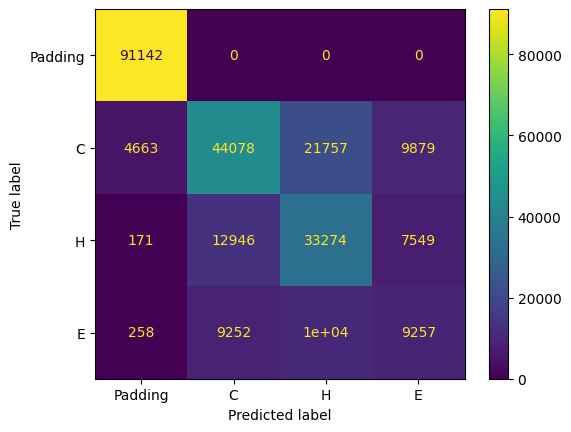

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

converted_hot = tf.argmax(y_test_hot, axis = -1).numpy()
converted_pred = tf.argmax(y_pred2, axis = -1).numpy()

print("===== With Oversampling =====\n")

# Output useful metrics

print(f"Default Accuracy: {accuracy_score(converted_hot.flatten(), converted_pred.flatten())}")
print(f"Q3 Accuracy: {q3_num(q3_acc(y_test_hot, y_pred2))}")
print("\n", classification_report(converted_hot.flatten(), converted_pred.flatten(), target_names = ["Padding", "C", "H", "E"], digits = 6))

# Create and display confusion matrix

cm2 = confusion_matrix(converted_hot.flatten(), converted_pred.flatten())
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["Padding", "C", "H", "E"])
disp2.plot()
disp2.figure_.savefig("disp2.pdf")
plt.show()